# Device free indoor localization using two parameters (RSSI and Illuminance)
## Project Summary
In this notebook, I will explore device free indoor localization dataset from 4x4 m room that i collect by myself. The dataset contains 64 columns obtained from measurement of two type sensors deployed in eight point across the room. The first sensor (ESP-32) is used to measure Received Signal Strength Indicator (RSSI) from every sensor (7 RSSI measurement x 8 total sensor = 56 columns), the second sensor (BH1750FVI) is used to measure illuminance around the room (1 illuminance measurement x 8 total sensor = 8 columns, 56+8 = 64 columns). The measurement is taken in 25 location (x = 0-4 m ; y = 0-4 m) around the 4x4 m room, and in each measurement, I label it with the coordinate of the location where the measurement was taken.

With this dataset, i will create an algorithm to detect location of the person from the sensor measurement using Convolutional Neural Networks (CNN) as Regression cases

In [6]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import learning_curve

In [7]:
#Import dataset
data = pd.read_csv('Dataset/tn7_hybrid_dataset.csv',index_col=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.0,-1.0,-4.0,-5.0,3.0,-3.0,-5.34,2.0,-1.0,...,-7.0,-6.0,0.0,-12.0,6.0,-1.0,0.0,10.50,1.0,1.0
1,2.0,-1.0,-3.0,-4.0,-6.0,-4.0,-3.0,-6.17,2.0,0.0,...,-3.0,1.0,-2.0,-2.0,5.0,-1.0,-1.0,12.16,1.0,1.0
2,1.0,1.0,-2.0,-3.0,-5.0,-1.0,-4.0,-7.00,4.0,1.0,...,-3.0,-1.0,0.0,0.0,7.0,-1.0,0.0,8.00,1.0,1.0
3,2.0,1.0,-6.0,-3.0,-4.0,-2.0,-1.0,-11.17,-1.0,-1.0,...,-1.0,-3.0,0.0,-1.0,5.0,0.0,-1.0,2.17,1.0,1.0
4,0.0,2.0,-4.0,-1.0,-3.0,0.0,-3.0,-12.00,-1.0,0.0,...,-5.0,-3.0,-1.0,0.0,4.0,0.0,-1.0,6.34,1.0,1.0


In the dataset, column 0-6 is RSSI measurement from first sensor at node 1, and column 7 is illuminance measurement from second sensor at node 1. The next 7 columns is RSSI measurement from first sensor at node 2, and the next column after that is illuminance measurement from second sensor at node 2, and so on until reach node 8 in column 56-63.

The final two columns 64 and 65 are the measurement label,defining the person location with coordinate x,y in 4x4 m area

In [8]:
#Separate feature x (columns 0-63) and label y (columns 64-65) from the dataset 
x = data.iloc[:,:-2]
y = data.iloc[:,[-2,-1]]

print(x)
print(y)

#Separate training data and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

        0    1    2     3    4    5    6      7    8    9  ...   54     55  \
0     1.0  0.0 -1.0  -4.0 -5.0  3.0 -3.0  -5.34  2.0 -1.0  ...  2.0  11.33   
1     2.0 -1.0 -3.0  -4.0 -6.0 -4.0 -3.0  -6.17  2.0  0.0  ...  1.0  10.50   
2     1.0  1.0 -2.0  -3.0 -5.0 -1.0 -4.0  -7.00  4.0  1.0  ...  0.0   8.00   
3     2.0  1.0 -6.0  -3.0 -4.0 -2.0 -1.0 -11.17 -1.0 -1.0  ...  1.0   3.00   
4     0.0  2.0 -4.0  -1.0 -3.0  0.0 -3.0 -12.00 -1.0  0.0  ... -2.0   3.00   
...   ...  ...  ...   ...  ...  ...  ...    ...  ...  ...  ...  ...    ...   
1475 -2.0  0.0 -1.0  -7.0 -1.0  0.0 -3.0   0.84  0.0  0.0  ... -3.0   0.00   
1476  0.0  1.0 -1.0  -6.0 -1.0  0.0  0.0   0.84 -1.0  0.0  ... -2.0   0.00   
1477 -1.0  0.0 -2.0  -7.0  0.0  1.0  1.0   0.84  0.0  2.0  ... -4.0   0.00   
1478  1.0 -2.0 -2.0 -11.0 -1.0  1.0  0.0   0.84  0.0 -1.0  ...  0.0   0.00   
1479 -1.0  0.0  0.0  -8.0 -1.0  1.0  0.0   0.84  0.0  1.0  ... -1.0  -0.83   

       56   57   58    59   60   61   62     63  
0    -7.0 -6.

In [9]:
np.unique(y_train)

array([1., 2., 3., 4., 5.])

In [10]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
632,1.0,-2.0,-1.0,-8.0,6.0,-1.0,1.0,0.00,2.0,0.0,...,-1.0,0.83,0.0,3.0,0.0,0.0,1.0,3.0,-1.0,0.84
317,-1.0,-1.0,0.0,-14.0,5.0,-2.0,1.0,-3.33,-2.0,0.0,...,2.0,-0.84,0.0,2.0,1.0,2.0,-2.0,0.0,-3.0,-1.66
1125,0.0,-1.0,-4.0,-3.0,-2.0,-2.0,-2.0,0.00,-2.0,1.0,...,-2.0,0.00,0.0,-1.0,3.0,-3.0,5.0,3.0,0.0,-0.84
58,0.0,1.0,-1.0,0.0,3.0,0.0,0.0,3.83,-1.0,-2.0,...,1.0,3.83,0.0,0.0,1.0,-3.0,3.0,2.0,2.0,-0.33
241,0.0,2.0,4.0,1.0,1.0,0.0,2.0,2.50,-1.0,-1.0,...,0.0,-11.67,1.0,-3.0,-1.0,0.0,1.0,0.0,0.0,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-1.0,2.0,1.0,2.0,-1.0,-2.0,-3.0,-1.16,-1.0,-1.0,...,0.0,5.50,-3.0,1.0,-1.0,-5.0,0.0,-5.0,0.0,4.67
835,-1.0,2.0,2.0,0.0,9.0,-4.0,-2.0,6.50,3.0,0.0,...,0.0,-2.67,-1.0,-1.0,0.0,-1.0,3.0,3.0,-2.0,2.34
1216,1.0,-1.0,-3.0,1.0,1.0,2.0,-1.0,0.00,0.0,-1.0,...,0.0,0.00,0.0,-1.0,-2.0,-1.0,0.0,0.0,-1.0,-0.84
559,1.0,0.0,2.0,-8.0,3.0,1.0,-1.0,0.00,0.0,1.0,...,0.0,-4.17,2.0,5.0,2.0,2.0,1.0,0.0,1.0,0.00


In [11]:
#Reshape the features to create nxn matrix so that it can be processed with CNN
X_train = X_train.to_numpy().reshape((X_train.shape[0], 8, 8, 1))
X_test = X_test.to_numpy().reshape((X_test.shape[0], 8, 8, 1))

In [12]:
X_train.shape

(1184, 8, 8, 1)

In [13]:
#Defining the function for normalized the features
def prep_pixels(train, test):

    train_norm = (train+100) / 200
    test_norm = (test+100) / 200
    # return normalized images
    return train_norm, test_norm

In [14]:
#Defining the custom evalution algorithm especially for evaluate the prediction of person location

def custom_mse(y_true, y_pred):
    err=y_true - y_pred
    err2= np.square(err)
    err3=np.sum(err2,axis=1)
    err4 =np.sqrt(err3)
    err5 =np.sum(err4)
    loss =err5/err.shape[0]
    
    return loss

def stdev(mse,y_true,y_pred):
    err= y_true - y_pred
    err2= np.square(err)
    err3= np.sum(err2,axis=1)
    err4 =np.sqrt(err3)
    err5 =err4-mse
    err6=np.square(err5)
    err7=np.sum(err6)
    dev = np.sqrt(err7/(err.shape[0]-1))
    
    return dev

In [15]:
#print({'filters': 1, 'hidden_layers': 3, 'kernel_size': 32, 'neurons': 100, 'opt':'SGD' })
#print({'filters_1': 1, 'filters_2': 2, 'filters_3': 1, 'hidden_layers': 2, 'kernel_size_1': 16, 'kernel_size_2': 32, 'kernel_size_3': 16, 'neurons': 100, 'opt': 'SGD'})
#print({'filters_1': 1, 'filters_2': 1, 'filters_3': 2, 'hidden_layers': 3, 'kernel_size_1': 32, 'kernel_size_2': 32, 'kernel_size_3': 32, 'neurons': 100, 'opt': 'sgd'})
#print({'filters_1': 1, 'filters_2': 1, 'filters_3': 1, 'hidden_layers': 3, 'kernel_size_1': 16, 'kernel_size_2': 32, 'kernel_size_3': 32, 'neurons': 100, 'opt': 'sgd'})
#print({'filters_1': 1, 'filters_2': 1, 'filters_3': 1, 'hidden_layers': 2, 'kernel_size_1': 16, 'kernel_size_2': 16, 'kernel_size_3': 16, 'neurons': 100, 'opt': 'sgd'})
#print('')
#print('with lux:')
#print({'filters_1': 1, 'filters_2': 1, 'filters_3': 1, 'hidden_layers': 3, 'kernel_size_1': 32, 'kernel_size_2': 16, 'kernel_size_3': 32, 'neurons': 100, 'opt': 'sgd'})

In [16]:
# # Defining the CNN Model used to predict the person location

# reg = regularizers.l2(5e-05)

# model = Sequential()

# model.add(Conv2D(32, (1, 1), activation='relu', kernel_initializer='he_uniform', input_shape=X_train[0].shape))

# model.add(Conv2D(16, (1, 1), activation='relu', kernel_initializer='he_uniform', input_shape=X_train[0].shape))

# model.add(Conv2D(16, (1, 1), activation='relu', kernel_initializer='he_uniform', input_shape=X_train[0].shape))

# model.add(Flatten())

# model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

# model.add(Dropout(0.2))

# model.add(Dense(2, activation='linear'))

# opt = Adam(learning_rate=0.001)
# model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
# model.summary()

In [17]:
# my_callbacks = [
#     keras.callbacks.EarlyStopping(patience=100,monitor='val_loss',mode="min"),
# ]
# history = model.fit(X_train, y_train, epochs=1200, batch_size=10, validation_split = 0.2, callbacks=my_callbacks)
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.title('model mean_squared_error')
# plt.ylabel('mean_squared_error')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#  # Save the model and architecture to single file
#model.save("model.h5")

In [18]:
from keras.models import load_model
 
# load model the that alreasy been trained
model = load_model('saved_model/model.h5')

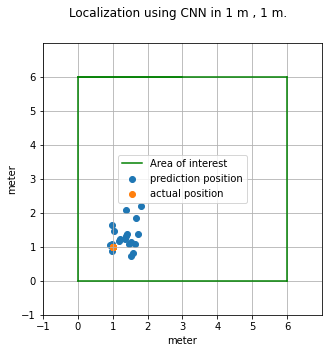

MAE: 0.57 meter.


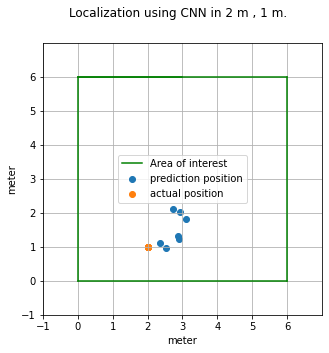

MAE: 0.98 meter.


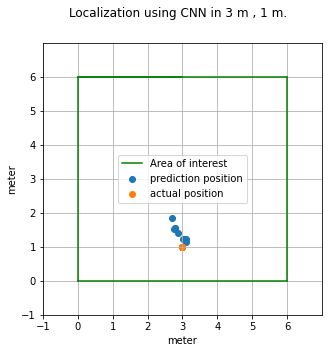

MAE: 0.44 meter.


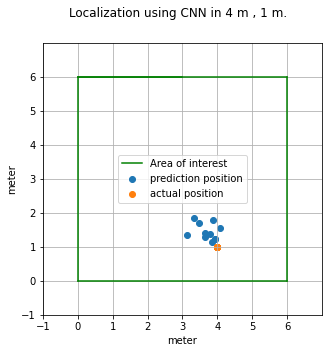

MAE: 0.58 meter.


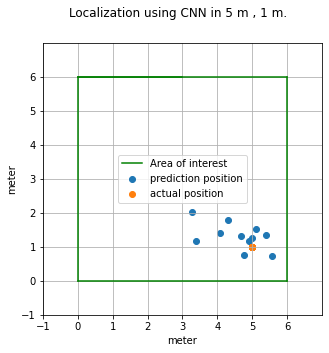

MAE: 0.79 meter.


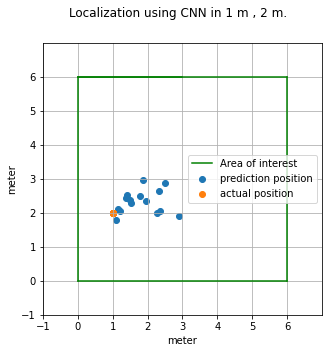

MAE: 0.94 meter.


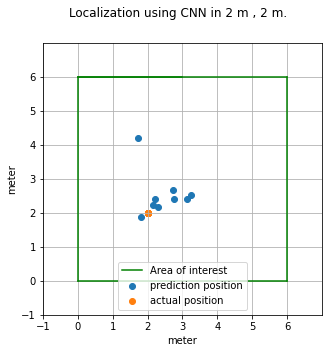

MAE: 0.88 meter.


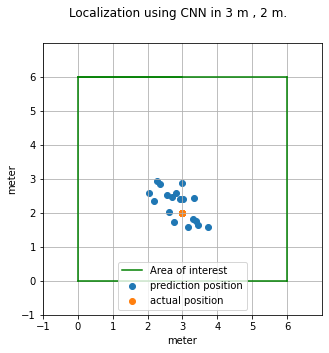

MAE: 0.66 meter.


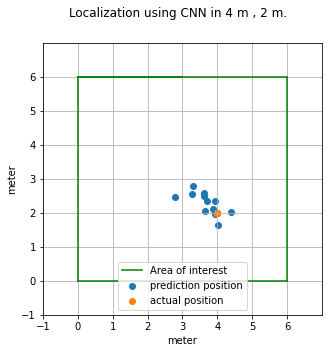

MAE: 0.57 meter.


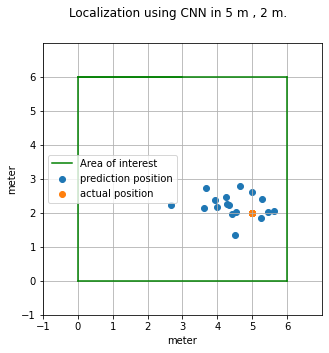

MAE: 0.88 meter.


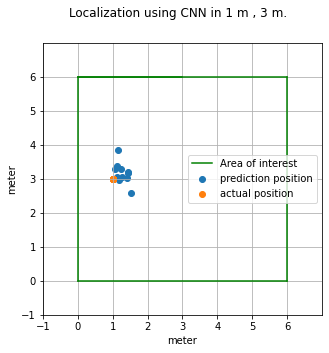

MAE: 0.42 meter.


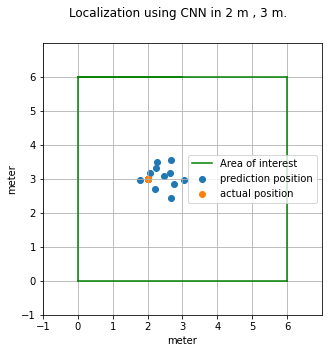

MAE: 0.59 meter.


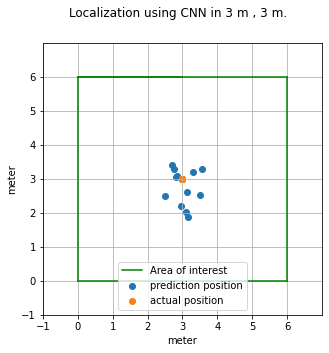

MAE: 0.58 meter.


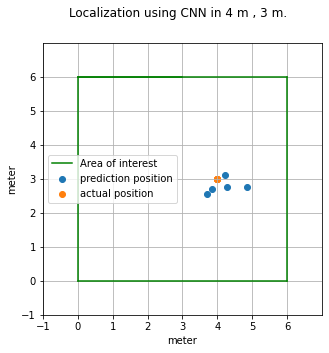

MAE: 0.47 meter.


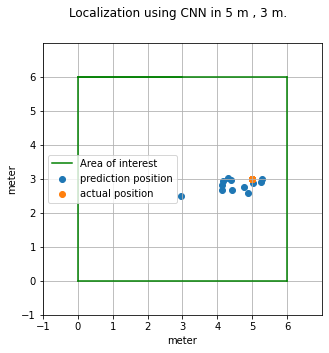

MAE: 0.68 meter.


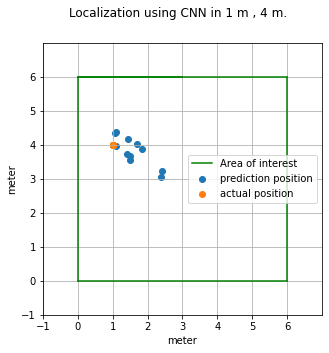

MAE: 0.72 meter.


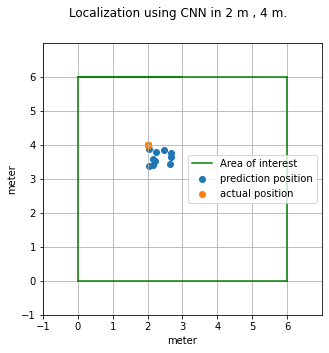

MAE: 0.55 meter.


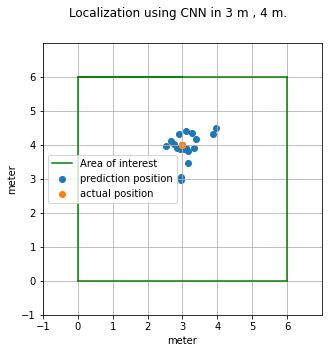

MAE: 0.47 meter.


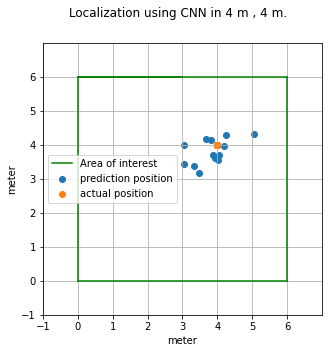

MAE: 0.59 meter.


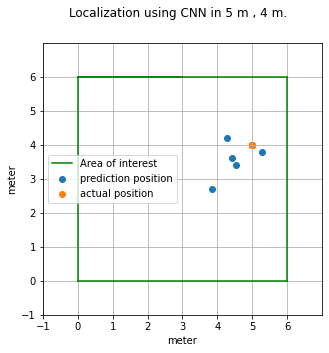

MAE: 0.85 meter.


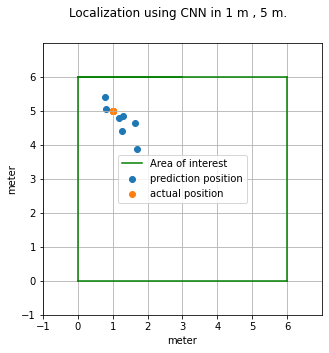

MAE: 0.57 meter.


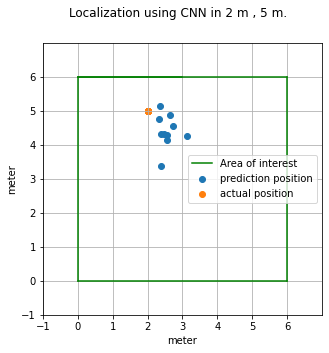

MAE: 0.89 meter.


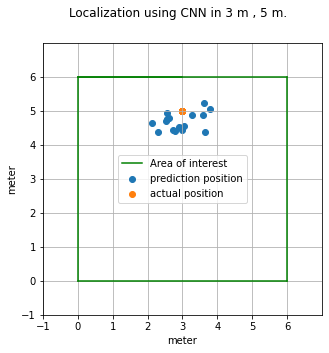

MAE: 0.61 meter.


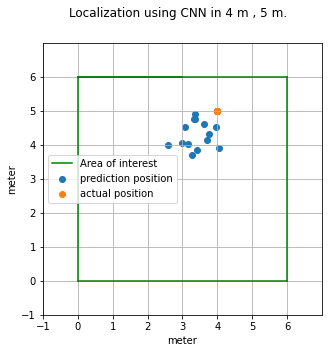

MAE: 1.00 meter.


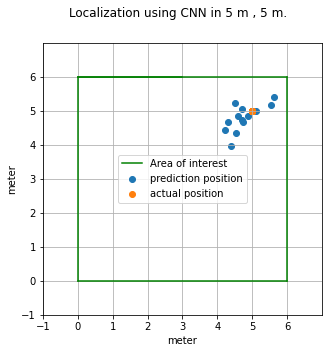

MAE: 0.57 meter.


In [19]:
# Defining the dataframe that will be used later to create the heatmap
heatmap = pd.DataFrame(index=[i for i in range(1,6)],columns=[n for n in range(1,6)])

#Plotting the prediction result in each location
for i in range(5):
    for n in range(5):
        X_test_tmp = X_test[(y_test.iloc[:,0]==1+1*n) & (y_test.iloc[:,1]==1+1*i)]
        y_test_tmp = y_test[(y_test.iloc[:,0]==1+1*n) & (y_test.iloc[:,1]==1+1*i)]
        
        if len(X_test_tmp) == 0:
            continue
            
        predict =  model.predict(X_test_tmp)

        fig = plt.figure(figsize=(5,5))
        fig.suptitle('Localization using CNN in {x} m , {y} m.'.format(x=1+1*n, y=1+1*i), fontsize=12)
        ax = fig.gca()
        ax.set(xlim=(-1,7), ylim=(-1, 7))
        ax.set_ylabel('meter')
        ax.set_xlabel('meter')
        plt.yticks(np.arange(-1, 7, step=1))
        plt.xticks(np.arange(-1, 7, step=1))
        x_1 = [0, 0]
        y_1 = [6, 6]
        x_2 = [0, 6]
        y_2 = [6, 6]
        x_3 = [6, 6]
        y_3 = [6, 0]
        x_4 = [6, 0]
        y_4 = [0, 0]
        x_5 = [0, 0]
        y_5 = [0, 6]
        x_6 = [0, 3]
        y_6 = [6, 6]
        plt.plot(x_1, y_1,color='green',label='Area of interest')
        plt.plot(x_2, y_2,color='green')
        plt.plot(x_3, y_3,color='green')
        plt.plot(x_4, y_4,color='green')
        plt.plot(x_5, y_5,color='green')
        plt.plot(x_6, y_6,color='green')
        plt.scatter(predict[:,0],predict[:,1],label='prediction position')
        plt.scatter(y_test_tmp.iloc[:,0],y_test_tmp.iloc[:,1],label='actual position')
        plt.grid()
        ax.legend()
        plt.show()
        
        mse = custom_mse(y_test_tmp.to_numpy(),predict)
        print('MAE: {:0.2f} meter.'.format(mse))
        heatmap[1+1*i][1+1*n]=mse

In [23]:
#Summary of the prediction
pred1 = model.predict(X_test_tmp)

error1= custom_mse(y_test_tmp.to_numpy(),pred1)

dev1 = stdev(error1,y_test_tmp.to_numpy(),pred1)

print('Error prediction: {:0.2f} meter.'.format(error1))
print('Deviation of the prediction: {:0.2f} meter.'.format(dev1))

Error prediction: 0.57 meter.
Deviation of the prediction: 0.31 meter.


In [21]:
heatmap=heatmap.transpose()
hm = pd.DataFrame(pd.DataFrame(index=[i for i in range(5,0,-1)],columns=[n for n in range(1,6)]))
for i in range(5):
    hm.iloc[(i)]=heatmap.iloc[4-1*i]

Text(0.5, 15.0, 'X (meter)')

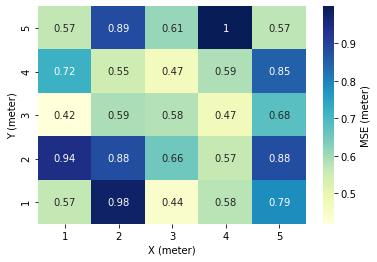

In [22]:
# Plot the error prediction in each location as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

ax=sns.heatmap(hm.astype(float),annot=True,cmap="YlGnBu",cbar_kws={'label': 'MSE (meter)'})
ax.set_ylim(len(hm.astype(float)),0, 0)
ax.set_ylabel('Y (meter)')
ax.set_xlabel('X (meter)')